# Deep Learning Introduction in NumPy

In [37]:
%matplotlib inline  
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## Data

In [38]:
X, y = make_moons(n_samples = 500, noise = 0.2, random_state = 101)

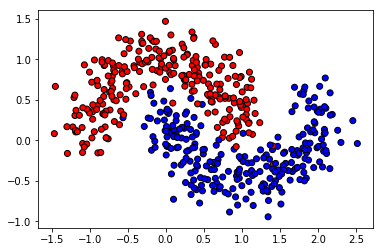

In [39]:
# visualisation
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c = y, edgecolors='k', cmap = cm_bright)

## Logistic Regression

In our example, the output of the logistic regression is a value between 0 and 1 that tells the probability of a point being blue or red. The input of the model are the coordinates of the point.

$$f_{\theta}(x) = \frac{1}{1+\exp(-(\theta_0 + \theta_1 x_1 + \ldots + \theta_n x_n))}$$

In [40]:
clf = LogisticRegressionCV()
clf.fit(X,y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

We plot the result. We see how the model is actually finding a hyperplane defined by $\theta_0 + \theta_1 x_1 + \ldots + \theta_n x_n = 0$ that tries to separate the data

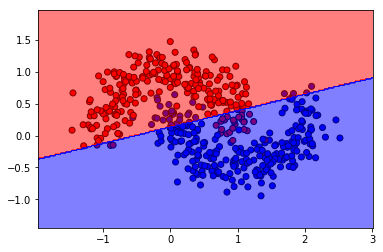

In [41]:
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c = y, edgecolors='k', cmap = cm_bright)
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.02 # step in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z_binary = Z>=0
Z_binary = Z_binary.reshape(xx.shape)
ax.contourf(xx, yy, Z_binary, cmap=cm_bright, alpha=.5)

## Neural Networks

### Ingredients

- Definition of the model to do a forward pass: $y = \sigma(W^{[L-1]}(\sigma(W^{[L-2]}(... \sigma(W^{[1]}x + b^{[1]})...)+b^{[L-2]}))+b^{[L-1]})$ where 
    - $\sigma$ is the activation function
    - $Wx + b$ is a linear function that goes from $\mathbb{R}^n$ to $\mathbb{R}^m$.
    - In our example, the output of the model is a value between 0 and 1 that tells the probability of a point being blue or red. The input of the model are the coordinates of the point. 
- Definition of a cost function that tells how good is the model in terms of its parameters: $$J(\theta), \text{where } \theta:=\{W^{[1]}, b^{[1]}, \ldots, W^{[L-1]}, b^{[L-1]}\}$$
- Optimisation of the cost function using gradient descent.
    - We need to apply the chain rule (backpropagation) in order to obtain $\partial_{\theta}J$ for each optimisation step.
   

#### Activation function and model definition

In [42]:
# activation function
def sigmoid(z):
    output = 1/(1+np.exp(-z))
    return output

In [43]:
# forward_model.
# function that takes the input x, and outputs the output of the model, as well as the intermediate layers
# I am defining a neural network with one hidden layer.
def forward_model(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # forward pass
    # hidden layer
    z2 = np.matmul(x,W1) + b1
    a2 = sigmoid(z2)
    
    # output layer
    z3 = np.matmul(a2,W2) + b2
    a3 = sigmoid(z3)
    
    return z2, a2, z3, a3

#### Loss function
Let $\mathcal{D} = \{(x^1, y^1), (x^2, y^2), \ldots, (x^N, y^N)\}$ be our training set, where $x^i\in \mathbb{R}^n$
We define the loss function as $$J(\theta) = \sum_{i=1}^{N} y^i \log(f_{\theta}(x^i)) + (1-y^i) \log(1-f_{\theta}(x^i))$$

In [44]:
def loss_fn(model, x, y):
    _,_,_,y_pred = forward_model(model, x)
    loss_batch = y * np.log(y_pred) + (1-y) * np.log(1-y_pred)
    return -np.sum(loss_batch)

#### Gradient descent step.
See for example (https://arxiv.org/pdf/1801.05894.pdf) for a general form of the gradient of the cost function for the parameters in each layer of the network.



In [45]:
def GD_step(model, x, y, lr = 0.001):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    z2, a2, z3, a3 = forward_model(model, x)
    
    delta3 = a3-y
    dW2 = np.matmul(a2.T,delta3)
    db2 = np.sum(delta3, axis=0, keepdims=True)
    
    delta2 = sigmoid(z2)*(1-sigmoid(z2)) * delta3.dot(W2.T)
    dW1 = np.matmul(x.T, delta2)
    db1 = np.sum(delta2, axis=0)
    
    W2 = W2 - lr * dW2
    b2 = b2 - lr * db2
    W1 = W1 - lr * dW1
    b1 = b1 - lr * db1
    
    model['W1'], model['b1'], model['W2'], model['b2'] = W1, b1, W2, b2
    return model

#### We put everything together for the training:
- Initialise $W^{[1]}, b^{[1]}, \ldots, W^{[L-1]}, b^{[L-1]}$.
- While Not convergence:
    - Calculate $J(\theta)$
    - Update $W^{[i]} := W^{[i]} - \alpha \cdot \partial_{W^{[i]}}J$
    - Update $b^{[i]} := b^{[i]} - \alpha \cdot \partial_{b^{[i]}}J$
    

In [46]:
def train(model, n_epochs, X, y):
    for epoch in range(n_epochs):
        model = GD_step(model, x=X, y=y)
        loss = loss_fn(model, x=X, y=y)
        if epoch%10 == 0:
            print("Epoch: {}/{}, loss: {}".format(epoch, n_epochs, loss))
    return model

In [47]:
n_hidden = 30
W1 = np.random.randn(2, n_hidden)
b1 = np.random.randn(1, n_hidden)
W2 = np.random.randn(n_hidden, 1)
b2 = np.random.randn(1,1)
model = {}
model['W1'], model['b1'], model['W2'], model['b2'] = W1, b1, W2, b2

model = train(model=model, n_epochs=10000, X=X, y=y.reshape(500,1))

Epoch: 0/10000, loss: 416.80988112104154
Epoch: 10/10000, loss: 153.1538137246289
Epoch: 20/10000, loss: 147.18651156054275
Epoch: 30/10000, loss: 142.9138809128617
Epoch: 40/10000, loss: 139.58369633385976
Epoch: 50/10000, loss: 136.86339690376906
Epoch: 60/10000, loss: 134.559997110865
Epoch: 70/10000, loss: 132.5502411787955
Epoch: 80/10000, loss: 130.75171756603294
Epoch: 90/10000, loss: 129.10762423014793
Epoch: 100/10000, loss: 127.57788729257942
Epoch: 110/10000, loss: 126.13370556331822
Epoch: 120/10000, loss: 124.75407341322459
Epoch: 130/10000, loss: 123.4234965292344
Epoch: 140/10000, loss: 122.13045187358594
Epoch: 150/10000, loss: 120.86632570340083
Epoch: 160/10000, loss: 119.62466664449789
Epoch: 170/10000, loss: 118.40065110152189
Epoch: 180/10000, loss: 117.19069460758054
Epoch: 190/10000, loss: 115.99216520866848
Epoch: 200/10000, loss: 114.80316926155771
Epoch: 210/10000, loss: 113.62238930541598
Epoch: 220/10000, loss: 112.44895982615742
Epoch: 230/10000, loss: 111.

Epoch: 2100/10000, loss: 41.70325414260536
Epoch: 2110/10000, loss: 41.6389426806505
Epoch: 2120/10000, loss: 41.57526180647355
Epoch: 2130/10000, loss: 41.512202322319425
Epoch: 2140/10000, loss: 41.44975521048489
Epoch: 2150/10000, loss: 41.387911628992924
Epoch: 2160/10000, loss: 41.32666290738707
Epoch: 2170/10000, loss: 41.26600054264215
Epoch: 2180/10000, loss: 41.20591619518786
Epoch: 2190/10000, loss: 41.14640168504144
Epoch: 2200/10000, loss: 41.08744898804639
Epoch: 2210/10000, loss: 41.02905023221385
Epoch: 2220/10000, loss: 40.97119769416352
Epoch: 2230/10000, loss: 40.913883795661
Epoch: 2240/10000, loss: 40.857101100248926
Epoch: 2250/10000, loss: 40.800842309968516
Epoch: 2260/10000, loss: 40.74510026216956
Epoch: 2270/10000, loss: 40.68986792640526
Epoch: 2280/10000, loss: 40.63513840141036
Epoch: 2290/10000, loss: 40.580904912159255
Epoch: 2300/10000, loss: 40.527160807002176
Epoch: 2310/10000, loss: 40.47389955487694
Epoch: 2320/10000, loss: 40.42111474259412
Epoch: 2

Epoch: 4170/10000, loss: 35.14431619832278
Epoch: 4180/10000, loss: 35.12914542813449
Epoch: 4190/10000, loss: 35.11405354818683
Epoch: 4200/10000, loss: 35.0990399768078
Epoch: 4210/10000, loss: 35.084104137647536
Epoch: 4220/10000, loss: 35.0692454596163
Epoch: 4230/10000, loss: 35.05446337682352
Epoch: 4240/10000, loss: 35.039757328517624
Epoch: 4250/10000, loss: 35.02512675902688
Epoch: 4260/10000, loss: 35.010571117700906
Epoch: 4270/10000, loss: 34.996089858853075
Epoch: 4280/10000, loss: 34.9816824417039
Epoch: 4290/10000, loss: 34.96734833032494
Epoch: 4300/10000, loss: 34.95308699358374
Epoch: 4310/10000, loss: 34.938897905089426
Epoch: 4320/10000, loss: 34.92478054313911
Epoch: 4330/10000, loss: 34.91073439066503
Epoch: 4340/10000, loss: 34.89675893518245
Epoch: 4350/10000, loss: 34.88285366873824
Epoch: 4360/10000, loss: 34.869018087860255
Epoch: 4370/10000, loss: 34.85525169350734
Epoch: 4380/10000, loss: 34.84155399102004
Epoch: 4390/10000, loss: 34.827924490072036
Epoch: 

Epoch: 6210/10000, loss: 33.127172954377144
Epoch: 6220/10000, loss: 33.12072104200638
Epoch: 6230/10000, loss: 33.11428988672089
Epoch: 6240/10000, loss: 33.10787936103777
Epoch: 6250/10000, loss: 33.10148933820318
Epoch: 6260/10000, loss: 33.09511969218526
Epoch: 6270/10000, loss: 33.088770297667246
Epoch: 6280/10000, loss: 33.08244103004045
Epoch: 6290/10000, loss: 33.07613176539739
Epoch: 6300/10000, loss: 33.06984238052494
Epoch: 6310/10000, loss: 33.063572752897514
Epoch: 6320/10000, loss: 33.057322760670274
Epoch: 6330/10000, loss: 33.05109228267246
Epoch: 6340/10000, loss: 33.04488119840067
Epoch: 6350/10000, loss: 33.038689388012216
Epoch: 6360/10000, loss: 33.03251673231857
Epoch: 6370/10000, loss: 33.02636311277873
Epoch: 6380/10000, loss: 33.02022841149278
Epoch: 6390/10000, loss: 33.01411251119535
Epoch: 6400/10000, loss: 33.00801529524921
Epoch: 6410/10000, loss: 33.00193664763884
Epoch: 6420/10000, loss: 32.9958764529641
Epoch: 6430/10000, loss: 32.989834596433866
Epoch:

Epoch: 8300/10000, loss: 32.07636568685749
Epoch: 8310/10000, loss: 32.072134055004824
Epoch: 8320/10000, loss: 32.06790424742334
Epoch: 8330/10000, loss: 32.063676181552424
Epoch: 8340/10000, loss: 32.05944977476177
Epoch: 8350/10000, loss: 32.055224944352226
Epoch: 8360/10000, loss: 32.05100160755718
Epoch: 8370/10000, loss: 32.046779681543526
Epoch: 8380/10000, loss: 32.04255908341305
Epoch: 8390/10000, loss: 32.03833973020372
Epoch: 8400/10000, loss: 32.034121538891206
Epoch: 8410/10000, loss: 32.0299044263904
Epoch: 8420/10000, loss: 32.02568830955706
Epoch: 8430/10000, loss: 32.02147310518953
Epoch: 8440/10000, loss: 32.01725873003055
Epoch: 8450/10000, loss: 32.01304510076919
Epoch: 8460/10000, loss: 32.00883213404282
Epoch: 8470/10000, loss: 32.004619746439204
Epoch: 8480/10000, loss: 32.00040785449873
Epoch: 8490/10000, loss: 31.996196374716654
Epoch: 8500/10000, loss: 31.991985223545427
Epoch: 8510/10000, loss: 31.987774317397253
Epoch: 8520/10000, loss: 31.98356357264654
Epo

#### Prediction

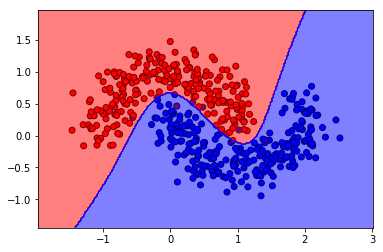

In [48]:
_,_,_,y_pred = forward_model(model, X)
y_pred = y_pred.ravel()

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c = y.ravel(), edgecolors='k', cmap = cm_bright)
_,_,_,Z = forward_model(model=model, x=np.c_[xx.ravel(), yy.ravel()])
Z_binary = Z>=0.5
Z_binary = Z_binary.reshape(xx.shape)
ax.contourf(xx, yy, Z_binary, cmap=cm_bright, alpha=.5)